# Drawsparse
<hr style="border-top-width: 4px; border-top-color: #34609b;">
Convert a THnSparse to a TTree using efficient iteration through the THnSparse
and draw a THnSparse using TParallelCoord.
The plot will contain one line for each filled bin,
with the bin's coordinates on each axis, and the bin's content on
the rightmost axis.

 Run as
```
   .L $ROOTSYS/tutorials/tree/drawsparse.C+
```




**Author:** Axel Naumann  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Tuesday, January 17, 2017 at 02:42 PM.</small></i>

In [1]:
%%cpp -d
#include "TParallelCoord.h"
#include "TParallelCoordVar.h"
#include "TROOT.h"
#include "TTree.h"
#include "TLeaf.h"
#include "THnSparse.h"
#include "TAxis.h"
#include "TCanvas.h"
#include "TRandom.h"
#include "TFile.h"
#include "TH3.h"

 A helper function is created: 

In [2]:
%%cpp -d
TTree* toTree(THnSparse* h)
{
   // Creates a TTree and fills it with the coordinates of all
   // filled bins. The tree will have one branch for each dimension,
   // and one for the bin content.

   Int_t dim = h->GetNdimensions();
   TString name(h->GetName()); name += "_tree";
   TString title(h->GetTitle()); title += " tree";

   TTree* tree = new TTree(name, title);
   Double_t* x = new Double_t[dim + 1];
   memset(x, 0, sizeof(Double_t) * (dim + 1));

   TString branchname;
   for (Int_t d = 0; d < dim; ++d) {
      if (branchname.Length())
         branchname += ":";
      TAxis* axis = h->GetAxis(d);
      branchname += axis->GetName();
      branchname += "/D";
   }
   tree->Branch("coord", x, branchname);
   tree->Branch("bincontent", &x[dim], "bincontent/D");

   Int_t *bins = new Int_t[dim];
   for (Long64_t i = 0; i < h->GetNbins(); ++i) {
      x[dim] = h->GetBinContent(i, bins);
      for (Int_t d = 0; d < dim; ++d) {
         x[d] = h->GetAxis(d)->GetBinCenter(bins[d]);
      }

      tree->Fill();
   }

   delete [] bins;
   //delete [] x;
   return tree;
}

 A helper function is created: 

In [3]:
%%cpp -d
void drawsparse_draw(THnSparse* h)
{
   // Draw a THnSparse using TParallelCoord, creating a temporary TTree.

   TTree* tree = toTree(h);

   TString whatToDraw;
   TIter iLeaf(tree->GetListOfLeaves());
   const TLeaf* leaf = 0;
   while ((leaf = (const TLeaf*)iLeaf())) {
      if (whatToDraw.Length())
         whatToDraw += ":";
      whatToDraw += leaf->GetName();
   }
   tree->Draw(whatToDraw, "", "para");
   TParallelCoord* parallelCoord = (TParallelCoord*)gPad->GetListOfPrimitives()->FindObject("ParaCoord");

   TIter iVar(parallelCoord->GetVarList());
   TParallelCoordVar* var = 0;
   for (Int_t d = 0;(var = (TParallelCoordVar*) iVar()) && d < h->GetNdimensions(); ++d) {
      TAxis* axis = h->GetAxis(d);
      var->SetHistogramBinning(axis->GetNbins());
      var->SetCurrentLimits(axis->GetXmin(), axis->GetXmax());
      var->SetTitle(axis->GetTitle());
   }
   var->SetTitle("bin content");
}

Create a thnsparse and draw it.

In [4]:
const Int_t ndims = 8;
Int_t bins[ndims] = {10, 10, 5, 30, 10, 4, 18, 12};
Double_t xmin[ndims] = {-5., -10., -1000., -3., 0.,   0., 0., 0.};
Double_t xmax[ndims] = {10., 70., 3000.,   3.,   5.,  2., 2., 5.};
THnSparse* hs = new THnSparseD("hs", "Sparse Histogram", ndims, bins, xmin, xmax);

Fill it

In [5]:
Double_t x[ndims];
for (Long_t i = 0; i < 100000; ++i) {
   for (Int_t d = 0; d < ndims; ++d) {
      switch (d) {
      case 0: x[d] = gRandom->Gaus()*2 + 3.; break;
      case 1:
      case 2:
      case 3: x[d] = (x[d-1]*x[d-1] - 1.5)/1.5 + (0.5*gRandom->Rndm()); break;
      default: x[d] = sin(gRandom->Gaus()*i/1000.) + 1.;
      }
   }
   hs->Fill(x);
}


TFile* f = new TFile("drawsparse.root","RECREATE");

TCanvas* canv = new TCanvas("hDrawSparse", "Drawing a sparse hist");
canv->Divide(2);

Draw it

In [6]:
canv->cd(1);
drawsparse_draw(hs);

Project it

In [7]:
canv->cd(2);
TH3D* h3proj = hs->Projection(2, 3, 6);
h3proj->SetLineColor(kOrange);
h3proj->SetDirectory(0);
h3proj->Draw("lego1");

Save everything to a file

In [8]:
canv->Write();
hs->Write();
h3proj->Write();

delete f;

Draw all canvases 

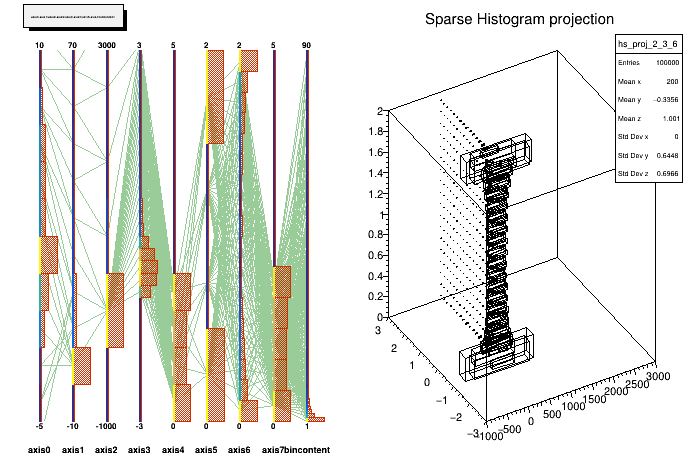

In [9]:
gROOT->GetListOfCanvases()->Draw()